In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests
import json
import sqlite3

In [2]:
DB_PATH = '/Users/ryan/Desktop/ShotQuality/nbatracking2324'
conn = sqlite3.connect(DB_PATH)

In [544]:
df = pd.read_sql_query(
    sql="SELECT * FROM testnba WHERE (action_type = '2pt' OR action_type = '3pt') AND shooter_name = court_player_name ORDER BY RANDOM() LIMIT 250000",
    con=conn
)

In [545]:
df.shape

(227620, 57)

In [546]:
df.columns

Index(['game_id', 'parent_play_id', 'play_id', 'team_id', 'shooter_id',
       'period', 'minutes', 'seconds', 'made', 'action_type',
       'play_descriptors', 'shot_x', 'shot_y', 'contest_score', 'spacing',
       'feature_store', 'feature_store_top_5', 'ev', 'shot_taking',
       'shooting_bench_direction', 'created_at_x', 'updated_at_x',
       'initial_updated_at', 'second_action', 'second_player_id', 'game_id_y',
       'court_player_id', 'player_location_type', 'court_x', 'court_y',
       'created_at_y', 'updated_at_y', 'possession_team', 'shooter_name',
       'court_player_name', 'secondary_name', 'game_datetime_utc',
       'competition_season_id', 'competition_id', 'home_team_id',
       'away_team_id', 'home_score', 'away_score', 'home_dynamic_sq_score',
       'away_dynamic_sq_score', 'home_initial_sq_score',
       'away_initial_sq_score', 'is_neutral', 'game_status',
       'game_descriptors', 'pbp_updated_at', 'created_at', 'updated_at',
       'event_type', 'home_team

In [547]:
df2 = df.copy()

In [548]:
df2 = df.copy()
df2['feature_store'] = df2['feature_store'].apply(json.loads)
feature_df = df2['feature_store'].apply(pd.Series)
df2 = pd.concat([df2, feature_df], axis=1)
df2.drop(columns=['feature_store','feature_store_top_5','ev','shot_taking'], inplace=True)

In [550]:
cols = ['created_at',
 'updated_at',
 'game_id',
 'parent_play_id',
 'play_id',
 'team_id',
 'shooter_name',
 'period',
 'minutes',
 'seconds',
 'made',
 'action_type',
 'play_descriptors',
 'shot_x',
 'shot_y',
 'contest_score',
 'spacing',
 'shooting_bench_direction',
 'initial_updated_at',
 'Player Dunk Prior',
 'Player Three Prior',
 'Player Midrange Prior',
 'Player Free Throw Prior',
 'Player Standing Layup Prior',
 'Defenders in Paint',
 'Is Attacking Right',
 'Closest Defender ID',
 'Shooter in the Paint',
 'Closest Defender Behind',
 'Closest Defender Inside',
 'Closest Defender Blocking',
 'Player Driving Layup Prior',
 'Shooter in Restricted Area',
 'Closest Defender Dunk Prior',
 'Closest Defender Three Prior',
 'Second-Closest Defender Behind',
 'Second-Closest Defender Inside',
 'Angle with the Closest Defender',
 'Closest Defender Midrange Prior',
 'Harmonic Mean Defender Distance',
 'Average Defender Distance (Feet)',
 'Defenders in the Restricted Area',
 'Number of Teammates in the Paint',
 'Second-Closest Defender Blocking',
 'Closest Defender Driving Layup Prior',
 'Closest Defender Standing Layup Prior',
 'Angle with the Second-Closest Defender',
 'Height of the Closest Defender (Inches)',
 'Weight of the Closest Defender (Pounds)',
 'Number of Defenders Closer to the Basket',
 'Number of Teammates in the Restricted Area',
 'Cosine of the Angle with the Closest Defender',
 'Height of the Second-Closest Defender (Inches)',
 'Weight of the Second-Closest Defender (Pounds)',
 'Cosine of the Angle with the Second-Closest Defender',
 "Height of the Closest Defender's Bounding Box (Pixels)",
 "Height of the Third-Closest Defender's Bounding Box (Pixels)",
 "Height of the Second-Closest Defender's Bounding Box (Pixels)",
 'Difference in Bounding Box Height with the Closest Defender (Pixels)',
 'Difference in Bounding Box Height with the Second-Closest Defender (Pixels)',
 'Shot Distance (ft.)',
 'Distance to the Closest Defender (Feet)',
 'Distance to the Second-Closest Defender (Feet)']

In [551]:
df2 = df2[cols]

In [552]:
df2.shape

(227620, 63)

In [553]:
drop_cols = df2.columns[df2[df2['action_type'].isin(['2pt', '3pt'])].isna().sum()/len(df2[df2['action_type'].isin(['2pt', '3pt'])]) > 0.45]

In [554]:
drop_cols

Index(['shooting_bench_direction', 'initial_updated_at'], dtype='object')

In [555]:
df2['action_type'].value_counts()

action_type
2pt    137642
3pt     89978
Name: count, dtype: int64

In [556]:
df2['made'].value_counts()

made
0    119628
1    107992
Name: count, dtype: int64

In [557]:
df2['pts'] = df2['action_type'].apply(lambda x: 2 if x == '2pt' else 3)

In [558]:
import pandas as pd
import ast
from sklearn.preprocessing import MultiLabelBinarizer

df2['play_descriptors_list'] = df2['play_descriptors'].apply(ast.literal_eval)

mlb = MultiLabelBinarizer()

play_desc_encoded = mlb.fit_transform(df2['play_descriptors_list'])

play_desc_df = pd.DataFrame(play_desc_encoded, columns=mlb.classes_)

df2 = df2.join(play_desc_df)

print("\nColumn names:", mlb.classes_)



Column names: ['alley_oop' 'catch_and_shoot' 'dunk' 'floater' 'hook' 'in_paint'
 'jumpshot' 'lay_up' 'off_cut' 'off_drive' 'pick_and_roll' 'post_up'
 'pull_up' 'reverse' 'step_back' 'tip_in' 'transition' 'turnaround']


In [559]:
corr = df2.select_dtypes(include=['number']).corr()

In [576]:
corrdf = pd.DataFrame(corr['made'])

In [577]:
corrdf['abs_corr'] = corrdf['made'].abs()

In [579]:
corrdf[corrdf['abs_corr'] >= 0.01].sort_values(by='abs_corr', ascending=False)

,made,abs_corr
made,1.000000,1.000000
jumpshot,-0.210279,0.210279
Shot Distance (ft.),-0.207697,0.207697
dunk,0.206364,0.206364
Number of Defenders Closer to the Basket,-0.197501,0.197501
in_paint,0.193958,0.193958
Cosine of the Angle with the Closest Defender,0.178757,0.178757
pts,-0.175005,0.175005
Second-Closest Defender Behind,0.167137,0.167137
Closest Defender Inside,-0.165122,0.165122


In [580]:
df2[["Height of the Third-Closest Defender's Bounding Box (Pixels)", "Height of the Second-Closest Defender's Bounding Box (Pixels)","Height of the Closest Defender's Bounding Box (Pixels)","Defenders in the Restricted Area","Number of Teammates in the Restricted Area"]].isna().sum().sort_values(ascending=False).head(20)

Defenders in the Restricted Area                                 95691
Number of Teammates in the Restricted Area                       95691
Height of the Third-Closest Defender's Bounding Box (Pixels)      2398
Height of the Second-Closest Defender's Bounding Box (Pixels)     2398
Height of the Closest Defender's Bounding Box (Pixels)            1765
dtype: int64

In [581]:
corrdf[corrdf['abs_corr'] >= 0.05].sort_values(by='abs_corr', ascending=False)

,made,abs_corr
made,1.000000,1.000000
jumpshot,-0.210279,0.210279
Shot Distance (ft.),-0.207697,0.207697
dunk,0.206364,0.206364
Number of Defenders Closer to the Basket,-0.197501,0.197501
in_paint,0.193958,0.193958
Cosine of the Angle with the Closest Defender,0.178757,0.178757
pts,-0.175005,0.175005
Second-Closest Defender Behind,0.167137,0.167137
Closest Defender Inside,-0.165122,0.165122


In [496]:
features = corrdf[corrdf['abs_corr'] >= 0.05].index.tolist()

In [586]:
features = corrdf[corrdf['abs_corr'] >= 0.01].index.tolist()

In [587]:
features

['minutes',
 'seconds',
 'made',
 'contest_score',
 'spacing',
 'Player Dunk Prior',
 'Player Three Prior',
 'Player Free Throw Prior',
 'Player Standing Layup Prior',
 'Defenders in Paint',
 'Shooter in the Paint',
 'Closest Defender Behind',
 'Closest Defender Inside',
 'Closest Defender Blocking',
 'Shooter in Restricted Area',
 'Second-Closest Defender Behind',
 'Second-Closest Defender Inside',
 'Harmonic Mean Defender Distance',
 'Average Defender Distance (Feet)',
 'Defenders in the Restricted Area',
 'Second-Closest Defender Blocking',
 'Number of Defenders Closer to the Basket',
 'Number of Teammates in the Restricted Area',
 'Cosine of the Angle with the Closest Defender',
 'Cosine of the Angle with the Second-Closest Defender',
 "Height of the Closest Defender's Bounding Box (Pixels)",
 "Height of the Third-Closest Defender's Bounding Box (Pixels)",
 "Height of the Second-Closest Defender's Bounding Box (Pixels)",
 'Shot Distance (ft.)',
 'Distance to the Closest Defender (F

In [590]:
drop = ['made','contest_score','Player Free Throw Prior','Player Dunk Prior','Player Three Prior','Player Standing Layup Prior']
features = [feat for feat in features if feat not in drop]


In [591]:
features

['minutes',
 'seconds',
 'spacing',
 'Defenders in Paint',
 'Shooter in the Paint',
 'Closest Defender Behind',
 'Closest Defender Inside',
 'Closest Defender Blocking',
 'Shooter in Restricted Area',
 'Second-Closest Defender Behind',
 'Second-Closest Defender Inside',
 'Harmonic Mean Defender Distance',
 'Average Defender Distance (Feet)',
 'Defenders in the Restricted Area',
 'Second-Closest Defender Blocking',
 'Number of Defenders Closer to the Basket',
 'Number of Teammates in the Restricted Area',
 'Cosine of the Angle with the Closest Defender',
 'Cosine of the Angle with the Second-Closest Defender',
 "Height of the Closest Defender's Bounding Box (Pixels)",
 "Height of the Third-Closest Defender's Bounding Box (Pixels)",
 "Height of the Second-Closest Defender's Bounding Box (Pixels)",
 'Shot Distance (ft.)',
 'Distance to the Closest Defender (Feet)',
 'Distance to the Second-Closest Defender (Feet)',
 'pts',
 'alley_oop',
 'catch_and_shoot',
 'dunk',
 'floater',
 'in_paint'

In [592]:
descriptor_features = ['alley_oop', 'catch_and_shoot', 'dunk', 'floater', 'hook', 'in_paint',
 'jumpshot', 'lay_up', 'off_cut', 'off_drive', 'pick_and_roll', 'post_up',
 'pull_up', 'reverse', 'step_back', 'tip_in', 'transition', 'turnaround']

# Add any that are missing
for feat in descriptor_features:
    if feat not in features:
        features.append(feat)

In [593]:
features

['minutes',
 'seconds',
 'spacing',
 'Defenders in Paint',
 'Shooter in the Paint',
 'Closest Defender Behind',
 'Closest Defender Inside',
 'Closest Defender Blocking',
 'Shooter in Restricted Area',
 'Second-Closest Defender Behind',
 'Second-Closest Defender Inside',
 'Harmonic Mean Defender Distance',
 'Average Defender Distance (Feet)',
 'Defenders in the Restricted Area',
 'Second-Closest Defender Blocking',
 'Number of Defenders Closer to the Basket',
 'Number of Teammates in the Restricted Area',
 'Cosine of the Angle with the Closest Defender',
 'Cosine of the Angle with the Second-Closest Defender',
 "Height of the Closest Defender's Bounding Box (Pixels)",
 "Height of the Third-Closest Defender's Bounding Box (Pixels)",
 "Height of the Second-Closest Defender's Bounding Box (Pixels)",
 'Shot Distance (ft.)',
 'Distance to the Closest Defender (Feet)',
 'Distance to the Second-Closest Defender (Feet)',
 'pts',
 'alley_oop',
 'catch_and_shoot',
 'dunk',
 'floater',
 'in_paint'

In [635]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# 1. Prepare features and target
# X = df2[features].drop(columns=['made','contest_score'], errors='ignore')
X = df2[features]

y = df2['made']

# 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Train LightGBM model
model = lgb.LGBMClassifier(n_estimators=200, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# 4. Predict xFG% (probability of make)
xfg_test = model.predict_proba(X_test)[:, 1]

# 5. Evaluate
print("Test ROC-AUC:", roc_auc_score(y_test, xfg_test))

# 6. Attach xFG% to  DataFrame
df2.loc[X_test.index, 'xFG%'] = xfg_test

player_xfg = pd.DataFrame(df2[df2['xFG%'].notna()].groupby('shooter_name')['xFG%'].mean())
player_xfg['FG%'] = df2[df2['xFG%'].notna()].groupby('shooter_name')['made'].mean()
player_xfg['xFG%_diff'] = player_xfg['FG%'] - player_xfg['xFG%']
player_xfg['count'] = df2[df2['xFG%'].notna()].groupby('shooter_name')['made'].count()
player_xfg['avg_shot_dist'] = df2[df2['xFG%'].notna()].groupby('shooter_name')['Shot Distance (ft.)'].mean()
player_xfg['avg_def_height'] = df2[df2['xFG%'].notna()].groupby('shooter_name')['Height of the Closest Defender (Inches)'].mean()
player_xfg['avg_def_dist'] = df2[df2['xFG%'].notna()].groupby('shooter_name')['Distance to the Closest Defender (Feet)'].mean()


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 86348, number of negative: 95748
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3171
[LightGBM] [Info] Number of data points in the train set: 182096, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.474189 -> initscore=-0.103334
[LightGBM] [Info] Start training from score -0.103334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

/var/folders/dc/q98d65zj19x9pb811hwrr98h0000gp/T/ipykernel_28546/3760776692.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.38027699 0.48923891 0.61706828 ... 0.29493282 0.4071031  0.32488604]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df2.loc[X_test.index, 'xFG%'] = xfg_test


<Axes: xlabel='xFG%', ylabel='Count'>

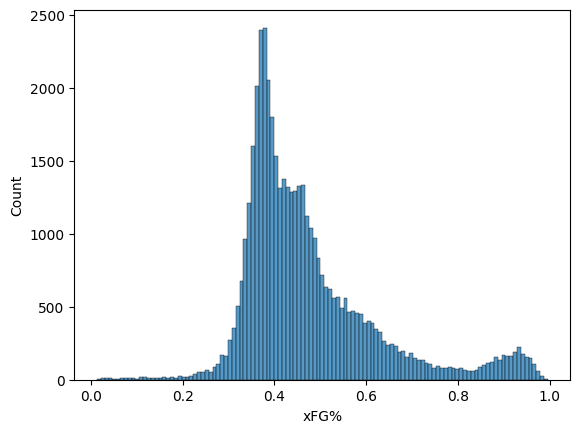

In [636]:
sns.histplot(df2,x='xFG%')

In [637]:
player_xfg.sort_values(by='count', ascending=False).head(10)

,xFG%,FG%,xFG%_diff,count,avg_shot_dist,avg_def_height,avg_def_dist
shooter_name,,,,,,,
Luka Doncic,0.414830,0.490196,0.075366,408,17.877618,79.107743,5.595325
Jalen Brunson,0.438698,0.494898,0.056200,392,15.051679,78.730065,5.291540
Jayson Tatum,0.457055,0.469101,0.012046,356,15.546005,79.109531,5.701974
Shai Gilgeous-Alexander,0.483038,0.535411,0.052373,353,11.724300,79.088994,4.901369
Anthony Edwards,0.470578,0.487106,0.016528,349,13.960202,79.261301,5.136542
Nikola Jokic,0.482026,0.554517,0.072491,321,10.576201,80.936986,4.599496
De'Aaron Fox,0.443555,0.429907,-0.013649,321,15.537141,78.807827,5.581360
Pascal Siakam,0.496714,0.559748,0.063035,318,10.150452,79.288081,4.701266
Stephen Curry,0.420289,0.501650,0.081361,303,19.112093,78.754940,6.073165


In [638]:
player_xfg[player_xfg['count'] > player_xfg['count'].mean()].sort_values(by='xFG%_diff', ascending=False).head(10)

,xFG%,FG%,xFG%_diff,count,avg_shot_dist,avg_def_height,avg_def_dist
shooter_name,,,,,,,
Alex Caruso,0.460914,0.603960,0.143046,101,17.954936,79.149453,7.629186
Simone Fontecchio,0.439292,0.543860,0.104567,114,18.050148,78.977077,6.407222
Al Horford,0.459109,0.561905,0.102796,105,16.968233,79.700040,7.088781
Brook Lopez,0.467462,0.558824,0.091361,170,16.871206,80.552581,6.062316
Aaron Nesmith,0.472941,0.561644,0.088703,146,14.958636,79.180339,6.104803
Andrew Nembhard,0.451599,0.537879,0.086280,132,14.591049,78.588048,5.757490
James Harden,0.416971,0.502392,0.085421,209,18.425995,78.459483,5.966949
Rui Hachimura,0.513088,0.597484,0.084396,159,13.380918,79.370579,5.452200
Kawhi Leonard,0.482028,0.565217,0.083189,253,13.577884,79.130748,4.986724


In [639]:
player_xfg[player_xfg['count'] > player_xfg['count'].mean()].sort_values(by='xFG%_diff', ascending=False).tail(10)

,xFG%,FG%,xFG%_diff,count,avg_shot_dist,avg_def_height,avg_def_dist
shooter_name,,,,,,,
Wendell Carter Jr.,0.532010,0.456522,-0.075488,92,14.359219,80.440428,6.202766
Cam Whitmore,0.504194,0.428571,-0.075622,98,15.006045,78.773314,5.770293
Saddiq Bey,0.465381,0.387755,-0.077626,147,16.313648,79.358833,7.362568
Jaden Hardy,0.438216,0.349057,-0.089159,106,16.833532,78.428170,6.163781
Luguentz Dort,0.469991,0.376712,-0.093279,146,17.108598,78.322023,6.935197
Russell Westbrook,0.510537,0.410072,-0.100465,139,11.310662,79.034727,5.412838
Keyonte George,0.415948,0.303571,-0.112377,168,17.923298,78.499696,5.879983
Kelly Oubre Jr.,0.508655,0.394872,-0.113783,195,12.814551,79.381446,5.120190
David Roddy,0.472914,0.318182,-0.154733,88,13.607527,79.619120,5.830246


<Axes: xlabel='xFG%', ylabel='FG%'>

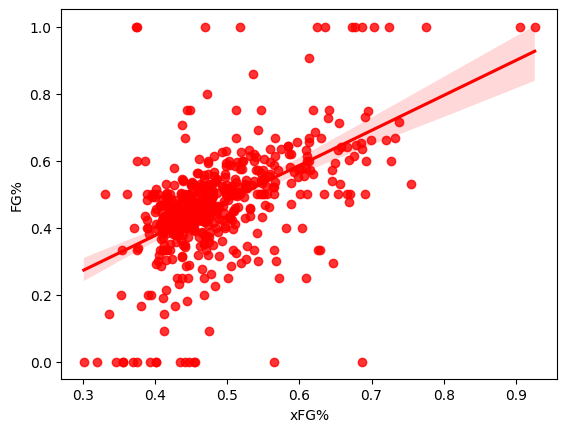

In [640]:
# sns.scatterplot(data=player_xfg, x='xFG%', y='FG%')
sns.regplot(data=player_xfg, x='xFG%', y='FG%', color='red')

<Axes: >

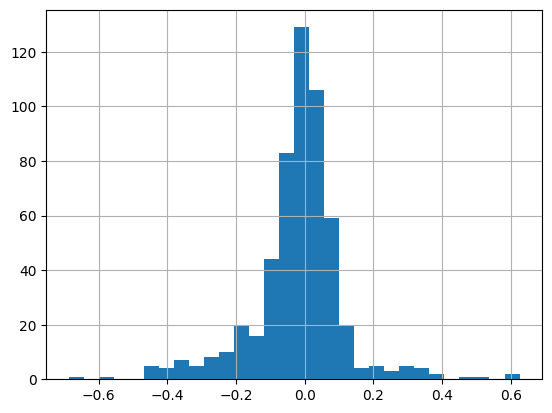

In [641]:
player_xfg['xFG%_diff'].hist(bins=30)

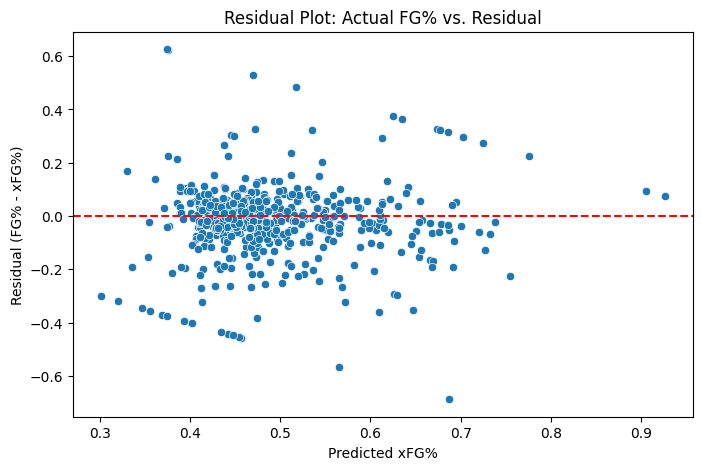

In [642]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(8,5))
sns.scatterplot(data=player_xfg, x='xFG%', y='xFG%_diff')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted xFG%')
plt.ylabel('Residual (FG% - xFG%)')
plt.title('Residual Plot: Actual FG% vs. Residual')
plt.show()

In [643]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,roc_auc_score,root_mean_squared_error

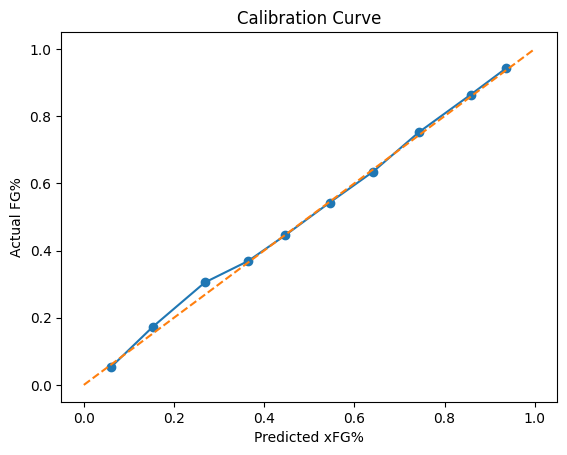

In [644]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, xfg_test, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1],'--')
plt.xlabel('Predicted xFG%')
plt.ylabel('Actual FG%')
plt.title('Calibration Curve')
plt.show()

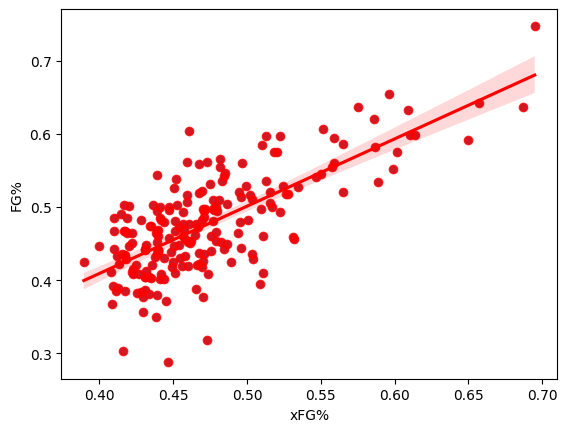

In [645]:
sns.scatterplot(data=player_xfg[player_xfg['count'] > player_xfg['count'].mean()], x='xFG%', y='FG%')
sns.regplot(data=player_xfg[player_xfg['count'] > player_xfg['count'].mean()], x='xFG%', y='FG%', color='red')
plt.show()

In [646]:
player_xfg['xFG_bin'] = pd.cut(player_xfg['xFG%'], bins=np.linspace(0, 1, 11))

bin_stats = player_xfg.groupby('xFG_bin').agg(
    avg_xFG=('xFG%', 'mean'),
    avg_FG=('FG%', 'mean'),
    count=('count', 'sum')
).reset_index()


/var/folders/dc/q98d65zj19x9pb811hwrr98h0000gp/T/ipykernel_28546/3932455319.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = player_xfg.groupby('xFG_bin').agg(


<Axes: xlabel='avg_xFG', ylabel='avg_FG'>

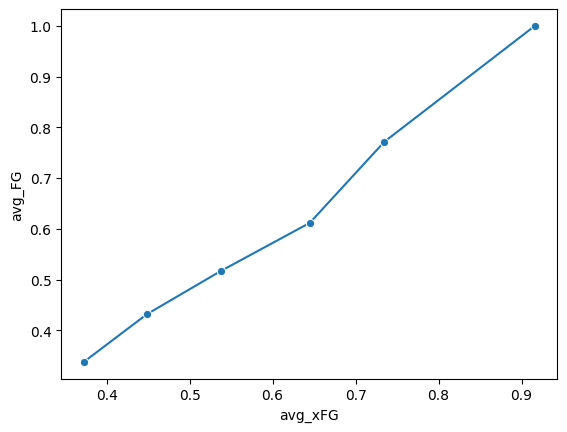

In [647]:
sns.lineplot(data=bin_stats, x='avg_xFG', y='avg_FG', marker='o')

In [649]:
player_xfg[['FG%','xFG%']].corr()

,FG%,xFG%
FG%,1.000000,0.538925
xFG%,0.538925,1.000000


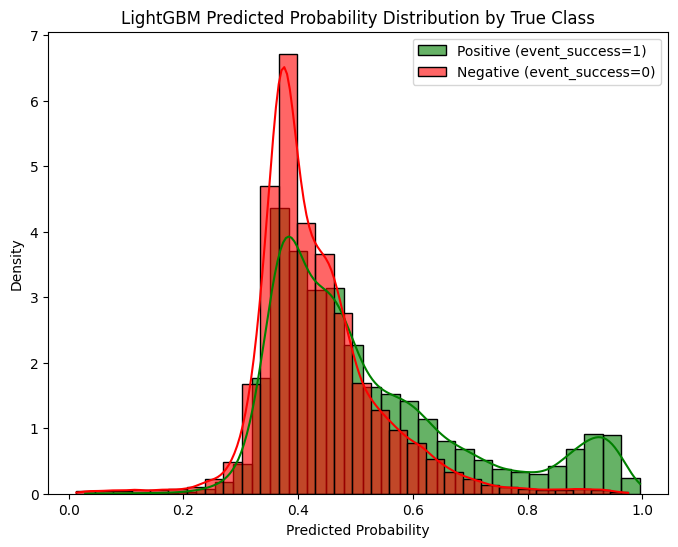

In [650]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))

# LightGBM predicted probabilities histogram by class
sns.histplot(xfg_test[y_test == 1], color='green', label='Positive (event_success=1)', kde=True, stat='density', bins=30, alpha=0.6)
sns.histplot(xfg_test[y_test == 0], color='red', label='Negative (event_success=0)', kde=True, stat='density', bins=30, alpha=0.6)

plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.title('LightGBM Predicted Probability Distribution by True Class')
plt.legend()
plt.show()

In [651]:
from sklearn.metrics import brier_score_loss

brier = brier_score_loss(y_test, xfg_test)
print(f"Brier Score: {brier:.4f}")

Brier Score: 0.2275


In [652]:
actual_fg = player_xfg[player_xfg['count'] > player_xfg['count'].mean()]["FG%"].values
predicted_fg = player_xfg[player_xfg['count'] > player_xfg['count'].mean()]["xFG%"].values

mae = mean_absolute_error(actual_fg, predicted_fg)
rmse = np.sqrt(mean_squared_error(actual_fg, predicted_fg))

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Mean Absolute Error (MAE): 0.0378
Root Mean Squared Error (RMSE): 0.0477


In [653]:
len(xfg_test)

45524

In [609]:
df2['xFG%'].isna().sum()

182096

In [654]:
player_xfg['xFG%'].describe()

count    545.000000
mean       0.487551
std        0.083466
min        0.301529
25%        0.433841
50%        0.467603
75%        0.521266
max        0.926039
Name: xFG%, dtype: float64

In [655]:
player_xfg[player_xfg['count'] > player_xfg['count'].mean()]['xFG%_diff'].describe()

count    208.000000
mean       0.003389
std        0.047692
min       -0.158413
25%       -0.027677
50%        0.003656
75%        0.035327
max        0.143046
Name: xFG%_diff, dtype: float64

In [656]:
player_xfg['xFG%_diff'].describe()

count    545.000000
mean      -0.019283
std        0.136364
min       -0.687032
25%       -0.064304
50%       -0.008489
75%        0.041748
max        0.625682
Name: xFG%_diff, dtype: float64

In [657]:
df2['xFG%'].describe()

count    45524.000000
mean         0.473799
std          0.149105
min          0.013354
25%          0.375490
50%          0.432193
75%          0.526230
max          0.995910
Name: xFG%, dtype: float64

In [658]:
df2.groupby('action_type')['xFG%'].mean()

action_type
2pt    0.543849
3pt    0.366625
Name: xFG%, dtype: float64

In [659]:
df2.groupby('action_type')['made'].mean()

action_type
2pt    0.545095
3pt    0.366356
Name: made, dtype: float64

<Axes: >

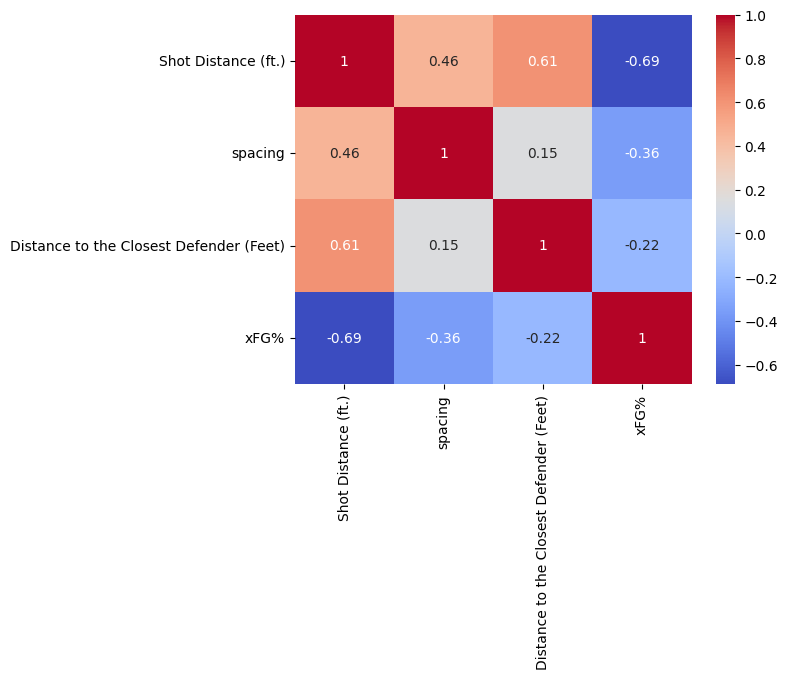

In [660]:
sns.heatmap(df2[['Shot Distance (ft.)','spacing','Distance to the Closest Defender (Feet)','xFG%']].corr(), annot=True, cmap='coolwarm')

In [661]:
descriptor_features

['alley_oop',
 'catch_and_shoot',
 'dunk',
 'floater',
 'hook',
 'in_paint',
 'jumpshot',
 'lay_up',
 'off_cut',
 'off_drive',
 'pick_and_roll',
 'post_up',
 'pull_up',
 'reverse',
 'step_back',
 'tip_in',
 'transition',
 'turnaround']

In [617]:
for feat in descriptor_features:
    print(feat + ": " + str(df2[df2[feat] == 1]['xFG%'].mean()))

alley_oop: 0.81076366
catch_and_shoot: 0.3763672
dunk: 0.8776285
floater: 0.4506612
hook: 0.47730067
in_paint: 0.5729315
jumpshot: 0.39444554
lay_up: 0.5573557
off_cut: 0.71083313
off_drive: 0.49007234
pick_and_roll: 0.4412127
post_up: 0.5076696
pull_up: 0.41753125
reverse: 0.6232727
step_back: 0.3787107
tip_in: 0.6000475
transition: 0.54500574
turnaround: 0.47274002


In [662]:
for feat in descriptor_features:
    print(feat + ": " + str(df2[df2[feat] == 1]['made'].mean()))

alley_oop: 0.8199817240328967
catch_and_shoot: 0.3802760284068069
dunk: 0.8775334813435508
floater: 0.4512563241358786
hook: 0.4753291497477544
in_paint: 0.5735366851613716
jumpshot: 0.3954254887254261
lay_up: 0.5560653899495411
off_cut: 0.7144085493182656
off_drive: 0.4898658741764549
pick_and_roll: 0.4386727478649484
post_up: 0.5040833568009011
pull_up: 0.36363636363636365
reverse: 0.6306169078446306
step_back: 0.3831757158918061
tip_in: 0.5998370008149959
transition: 0.5462921682270768
turnaround: 0.4702776101388051


In [330]:
curry = pd.read_sql_query(
    sql="SELECT * FROM testnba WHERE (action_type = '2pt' OR action_type = '3pt') AND shooter_name = court_player_name AND court_player_name = 'Kyrie Irving'",
    con=conn
)

In [530]:
curry.head()

,game_id,parent_play_id,play_id,team_id,shooter_id,period,minutes,seconds,made,action_type,...,floater,hook,off_drive,pick_and_roll,post_up,pull_up,step_back,turnaround,play_descriptors_parsed,eFG%
0,338647,6,21,95600.0,1186791,1,11,0.0,0,2pt,...,0,0,1,0,0,0,0,0,"[lay_up, in_paint, off_drive]",0.577463
1,338647,28,61,95600.0,1186791,1,7,0.0,0,3pt,...,0,0,0,0,0,0,0,0,[jumpshot],0.357929
2,338647,56,110,95600.0,1186791,1,3,16.0,1,3pt,...,0,0,0,0,0,0,0,0,[jumpshot],0.501443
3,338647,71,138,95600.0,1186791,1,1,35.0,0,2pt,...,0,0,1,0,0,0,0,0,"[lay_up, in_paint, off_drive]",0.261034
4,338647,80,154,95600.0,1186791,1,0,31.7,1,2pt,...,0,0,1,1,0,0,0,0,"[pick_and_roll, in_paint, lay_up, off_drive]",0.341654


In [332]:
curry['feature_store'] = curry['feature_store'].apply(json.loads)
feature_df_2 = curry['feature_store'].apply(pd.Series)
curry = pd.concat([curry, feature_df_2], axis=1)
curry.drop(columns=['feature_store','feature_store_top_5','ev','shot_taking'], inplace=True)

In [333]:
for col in features:
    if col not in curry.columns:
        curry[col] = 0


In [334]:
curry['play_descriptors_parsed'] = curry['play_descriptors'].apply(ast.literal_eval)


In [335]:
for desc in descriptor_features:
    curry[desc] = curry['play_descriptors_parsed'].apply(lambda x: int(desc in x))

In [336]:
curry

,game_id,parent_play_id,play_id,team_id,shooter_id,period,minutes,seconds,made,action_type,...,transition,floater,hook,off_drive,pick_and_roll,post_up,pull_up,step_back,turnaround,play_descriptors_parsed
0,338647,6,21,95600.0,1186791,1,11,0.0,0,2pt,...,0,0,0,1,0,0,0,0,0,"[lay_up, in_paint, off_drive]"
1,338647,28,61,95600.0,1186791,1,7,0.0,0,3pt,...,0,0,0,0,0,0,0,0,0,[jumpshot]
2,338647,56,110,95600.0,1186791,1,3,16.0,1,3pt,...,0,0,0,0,0,0,0,0,0,[jumpshot]
3,338647,71,138,95600.0,1186791,1,1,35.0,0,2pt,...,0,0,0,1,0,0,0,0,0,"[lay_up, in_paint, off_drive]"
4,338647,80,154,95600.0,1186791,1,0,31.7,1,2pt,...,0,0,0,1,1,0,0,0,0,"[pick_and_roll, in_paint, lay_up, off_drive]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1443,1497326,217,402,95600.0,1186791,3,4,32.0,0,2pt,...,0,0,0,0,1,0,0,0,0,"[pick_and_roll, jumpshot]"
1444,1497326,264,487,95600.0,1186791,4,9,28.0,0,3pt,...,0,0,0,1,0,0,0,1,0,"[step_back, jumpshot, off_drive]"
1445,1497326,274,504,95600.0,1186791,4,7,42.0,1,3pt,...,0,0,0,0,1,0,0,0,0,"[pick_and_roll, jumpshot]"
1446,1497326,279,512,95600.0,1186791,4,6,35.0,0,2pt,...,0,0,0,0,0,0,0,0,0,[jumpshot]


In [532]:
preds = model.predict_proba(curry[features].drop(columns=['made','contest_score'], errors='ignore'))

In [533]:
curry['eFG%'] = preds[:, 1]

In [534]:
curry.groupby('action_type')['eFG%'].mean()

action_type
2pt    0.495651
3pt    0.403678
Name: eFG%, dtype: float32

In [535]:
curry.groupby('action_type')['made'].mean()

action_type
2pt    0.541436
3pt    0.419890
Name: made, dtype: float64

In [536]:
curry.groupby('made')['eFG%'].mean()

made
0    0.421150
1    0.501841
Name: eFG%, dtype: float32

In [537]:
curry['eFG%'].mean()

0.461161

In [538]:
curry['made'].mean()

0.4958563535911602

In [345]:
descriptor_features

['alley_oop',
 'catch_and_shoot',
 'dunk',
 'floater',
 'hook',
 'in_paint',
 'jumpshot',
 'lay_up',
 'off_cut',
 'off_drive',
 'pick_and_roll',
 'post_up',
 'pull_up',
 'reverse',
 'step_back',
 'tip_in',
 'transition',
 'turnaround']

In [360]:
curry[(curry['eFG%'] < 0.10) * (curry['made'] == 1)][['game_datetime_utc','action_type','play_descriptors','game_name','eFG%','period','minutes','seconds']]

,game_datetime_utc,action_type,play_descriptors,game_name,eFG%,period,minutes,seconds
272,01-02-2024,3pt,"[""catch_and_shoot"", ""jumpshot""]",Utah Jazz vs Dallas Mavericks,0.079807,4,9,57.0
288,01-06-2024,2pt,"[""pick_and_roll"", ""turnaround"", ""jumpshot""]",Dallas Mavericks vs Portland Trail Blazers,0.056747,1,9,27.0
915,03-27-2024,3pt,"[""pick_and_roll"", ""jumpshot""]",Sacramento Kings vs Dallas Mavericks,0.095081,3,10,18.0
1113,04-27-2024,3pt,"[""jumpshot"", ""off_drive""]",Dallas Mavericks vs Los Angeles Clippers,0.028600,4,8,1.0
1288,05-25-2024,3pt,"[""jumpshot""]",Minnesota Timberwolves vs Dallas Mavericks,0.090078,4,10,23.0


<Axes: xlabel='eFG%', ylabel='Count'>

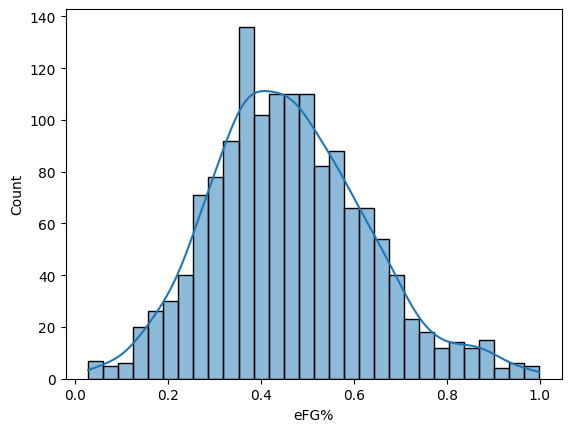

In [349]:
sns.histplot(curry['eFG%'], bins=30, kde=True)

In [669]:
from matplotlib.patches import Circle, Rectangle, Arc
import matplotlib.pyplot as plt



def create_nba_full_court(ax=None, court_color='#dfbb85',
                          lw=3, lines_color='black', lines_alpha=0.5,
                          paint_fill='blue', paint_alpha=0.4,
                          inner_arc=False):
    if ax is None:
        ax = plt.gca()

    # Create Pathes for Court Lines
    center_circle = Circle((94/2, 50/2), 6,
                           linewidth=lw, color=lines_color, lw=lw,
                           fill=False, alpha=lines_alpha)
    hoop_left = Circle((5.25, 50/2), 1.5 / 2,
                       linewidth=lw, color=lines_color, lw=lw,
                       fill=False, alpha=lines_alpha)
    hoop_right = Circle((94-5.25, 50/2), 1.5 / 2,
                        linewidth=lw, color=lines_color, lw=lw,
                        fill=False, alpha=lines_alpha)

    # Paint: 16 feet wide, 19 feet from baseline
    left_paint = Rectangle((0, 50/2 - 8), 19, 16,
                           fill=paint_fill, alpha=paint_alpha,
                           lw=lw, edgecolor=None)
    right_paint = Rectangle((94-19, 50/2 - 8), 19, 16,
                            fill=paint_fill, alpha=paint_alpha,
                            lw=lw, edgecolor=None)

    left_paint_border = Rectangle((0, 50/2 - 8), 19, 16,
                                  fill=False, alpha=lines_alpha,
                                  lw=lw, edgecolor=lines_color)
    right_paint_border = Rectangle((94-19, 50/2 - 8), 19, 16,
                                   fill=False, alpha=lines_alpha,
                                   lw=lw, edgecolor=lines_color)

    # Arcs at top of paint (6ft radius)
    left_arc = Arc((19, 50/2), 12, 12, theta1=-90, theta2=90,
                   color=lines_color, lw=lw, alpha=lines_alpha)
    right_arc = Arc((94-19, 50/2), 12, 12, theta1=90, theta2=-90,
                    color=lines_color, lw=lw, alpha=lines_alpha)

    # Lane markers (using standard spacing — could be customized more)
    # You can replicate lane markers symmetrically like before

    # Three-point lines (23.75 ft from basket, 22 ft in corners)
    corner_y = 3  # 22 ft from hoop to corner along baseline
    arc_radius = 23.75
    arc_diameter = arc_radius * 2
    three_pt_left = Arc((5.25, 50/2), arc_diameter, arc_diameter,
                        theta1=-69, theta2=69,
                        color=lines_color, lw=lw, alpha=lines_alpha)
    three_pt_right = Arc((94-5.25, 50/2), arc_diameter, arc_diameter,
                         theta1=180-69, theta2=180+69,
                         color=lines_color, lw=lw, alpha=lines_alpha)

    # 22-foot corner line (~14 feet from baseline to break point)
    ax.plot((0, 14), (corner_y, corner_y), color=lines_color, lw=lw, alpha=lines_alpha)
    ax.plot((0, 14), (50-corner_y, 50-corner_y), color=lines_color, lw=lw, alpha=lines_alpha)
    ax.plot((94-14, 94), (corner_y, corner_y), color=lines_color, lw=lw, alpha=lines_alpha)
    ax.plot((94-14, 94), (50-corner_y, 50-corner_y), color=lines_color, lw=lw, alpha=lines_alpha)

    # Add Patches
    ax.add_patch(left_paint)
    ax.add_patch(right_paint)
    ax.add_patch(left_paint_border)
    ax.add_patch(right_paint_border)
    ax.add_patch(center_circle)
    ax.add_patch(hoop_left)
    ax.add_patch(hoop_right)
    ax.add_patch(left_arc)
    ax.add_patch(right_arc)
    ax.add_patch(three_pt_left)
    ax.add_patch(three_pt_right)

    if inner_arc:
        left_inner_arc = Arc((19, 50/2), 12, 12, theta1=90, theta2=-90,
                             color=lines_color, lw=lw, alpha=lines_alpha, ls='--')
        right_inner_arc = Arc((94-19, 50/2), 12, 12, theta1=-90, theta2=90,
                              color=lines_color, lw=lw, alpha=lines_alpha, ls='--')
        ax.add_patch(left_inner_arc)
        ax.add_patch(right_inner_arc)

    # Restricted area (4 ft radius from center of basket)
    restricted_left = Arc((5.25, 50/2), 8, 8, theta1=-90, theta2=90,
                          color=lines_color, lw=lw, alpha=lines_alpha)
    restricted_right = Arc((94-5.25, 50/2), 8, 8, theta1=90, theta2=-90,
                           color=lines_color, lw=lw, alpha=lines_alpha)
    ax.add_patch(restricted_left)
    ax.add_patch(restricted_right)

    # Backboards
    ax.plot((4, 4), ((50/2) - 3, (50/2) + 3), color=lines_color, lw=lw*1.5, alpha=lines_alpha)
    ax.plot((94-4, 94-4), ((50/2) - 3, (50/2) + 3), color=lines_color, lw=lw*1.5, alpha=lines_alpha)
    ax.plot((4, 4.6), (50/2, 50/2), color=lines_color, lw=lw, alpha=lines_alpha)
    ax.plot((94-4, 94-4.6), (50/2, 50/2), color=lines_color, lw=lw, alpha=lines_alpha)

    # Halfcourt line
    ax.axvline(94/2, color=lines_color, lw=lw, alpha=lines_alpha)

    # Court border
    border = Rectangle((0.3, 0.3), 94 - 0.4, 50 - 0.4, fill=False, lw=3,
                       color='black', alpha=lines_alpha)
    ax.add_patch(border)

    # Plot Limit
    ax.set_xlim(0, 94)
    ax.set_ylim(0, 50)
    ax.set_facecolor(court_color)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    return ax


In [694]:
features

['minutes',
 'seconds',
 'spacing',
 'Defenders in Paint',
 'Shooter in the Paint',
 'Closest Defender Behind',
 'Closest Defender Inside',
 'Closest Defender Blocking',
 'Shooter in Restricted Area',
 'Second-Closest Defender Behind',
 'Second-Closest Defender Inside',
 'Harmonic Mean Defender Distance',
 'Average Defender Distance (Feet)',
 'Defenders in the Restricted Area',
 'Second-Closest Defender Blocking',
 'Number of Defenders Closer to the Basket',
 'Number of Teammates in the Restricted Area',
 'Cosine of the Angle with the Closest Defender',
 'Cosine of the Angle with the Second-Closest Defender',
 "Height of the Closest Defender's Bounding Box (Pixels)",
 "Height of the Third-Closest Defender's Bounding Box (Pixels)",
 "Height of the Second-Closest Defender's Bounding Box (Pixels)",
 'Shot Distance (ft.)',
 'Distance to the Closest Defender (Feet)',
 'Distance to the Second-Closest Defender (Feet)',
 'pts',
 'alley_oop',
 'catch_and_shoot',
 'dunk',
 'floater',
 'in_paint'

In [695]:
import pickle
pickle.dump(model, open('xFG_model.pkl', 'wb'))